# Orders - Multivariate Regression of  the `review_score`

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
# Import modules 
import pandas as pd
import os as os
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats as sp
import math
from sklearn.metrics import mean_squared_error




⚠️ You are strongly advised to:
* 💾 download the solution for yesterday's optional `distance_seller_customer` function if you didn't have time to code it
* 👥 copy-paste it into your `olist/orders.py` file



👇 First things first, import the `orders` dataset

In [10]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)

Let's recall our simple analysis from yesterday's exercise: 

Based on our correlation matrix down below 👇, we can notice that `review_score` is mostly correlated with  two features : `wait_time` and `delay_vs_expected`. However, these two features are also highly correlated with each other. 

In this exercise, we will use `statsmodels` to distinguish the effect of one feature, **holding the other features constant**.

<AxesSubplot:>

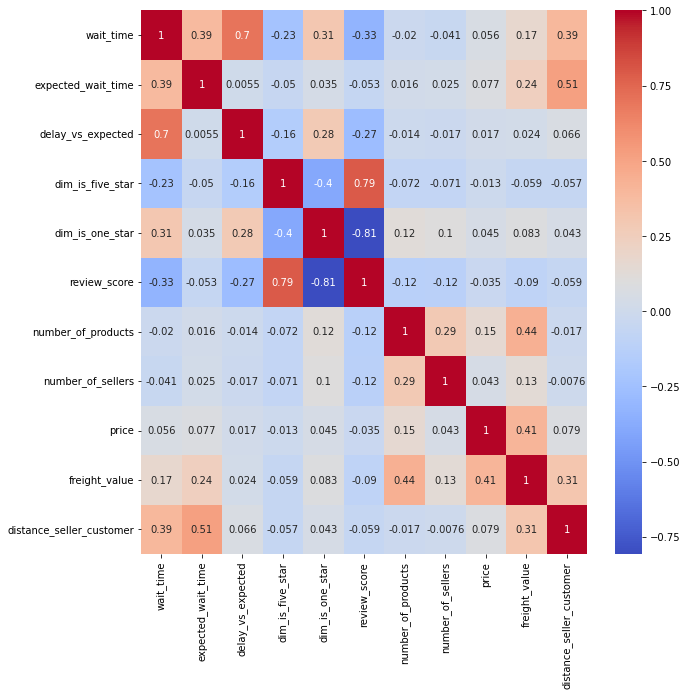

In [11]:
plt.figure(figsize = (10, 10))

sns.heatmap(
    orders.corr(), 
    cmap = 'coolwarm', 
    annot = True, 
    annot_kws = {"size": 10}
)

## 1 - Univariate regression

❓Use [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html) with `statsmodels.formula.api` to quickly make
 - `model1`: an ols regression of `review_score` over `wait_time`
 - `model2`: an ols regression of `review_score` over `delay_vs_expected`

For each, print the `summary` table and interpret the results:
- Make sure to understand how these results match those of the seaborn regplot
- Read the regression performance metric `R-squared`, as well as `individual regression coefficients`, `t-values`, `p-values`, and `95% confidence intervals`

***Model 1***:

In [230]:
model1 = smf.ols(formula = 'review_score ~ wait_time', data = orders).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                 1.204e+04
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:20:39   Log-Likelihood:            -1.5441e+05
No. Observations:               95872   AIC:                         3.088e+05
Df Residuals:                   95870   BIC:                         3.089e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1555      0.004   1062.227      0.000       4.148       4.163
wait_time     -0.4293      0.004   -109.730      0.000      -0.437      -0.422
==============================================================================
Omnibus:                    19552.934   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35454.407
Skew:                          -1.300   Prob(JB):                         0.00
Kurtosis:                       4.453   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***Model 2***:

In [231]:
model2 = smf.ols(formula = 'review_score ~ delay_vs_expected',data = orders).fit()
model2

## 2 - Multivariate regression

❓ What is the impact on `review_score` of adding one day of `delay_vs_expected` to the order, **holding `wait_time` constant**? Which of the two features is the most explicative for the low `review_score`?

For that purpose, run an OLS model `model3` where both `wait_time` and `delay_vs_expected` are the features (independent variables), and `review_score` is the target (dependent variable)

***Model 3***:

In [232]:
model3 = smf.ols(formula = 'review_score ~ delay_vs_expected + wait_time ',data = orders).fit()
model3

----
👉 Our multivariate regression allows us to isolate the impact of one feature, while controlling the effect of other features. These new coefficients are called **`partial correlation coefficients`**. 

❓Can you notice the difference with the **simple regression** coefficients computed with *seaborn* above? 

❓What can you say about the relative slopes for `wait_time` and `delay_vs_expected`? 


> YOUR ANSWER HERE

<details>
    <summary>- 💡 Solution 💡-</summary>

- Holding `wait_time` constant, each additional day of `delay` reduces the review_score on average by 0.0205 [0.023 - 0.018] points
- Holding `delay` constant, each additional day of `wait_time` reduces the review_score on average by 0.0383 [0.039 - 0.037] points

Contrary to what was found with the simple bivariate correlation analysis, `delay` is actually less impactful than `wait_time` in driving lower `review_score`! This interesting finding demonstrates the importance of multi-variate regression to remove the potential impact of confounding factors

---
❌ R-squared is quite low: no more than 12% of the variations of review_score is explained by the combined variations of `wait_time` and `delay_vs_expected`. 

✅ Let's try to add more features to our regression to improve the explainability of the linear regression.

👉 Create a new OLS `model4` with more features from the `orders` dataset.
- ⚠️ Do not create **data leaks**: do not add features that are directly derived from the `review_score`
- ⚠️ Do not add two features perfectly collinear with each other
- ⚖️  Transform each feature $X_i$ into its respective z-score $Z_i = \frac{X_i - \mu_i}{\sigma_i}$ in order to compare the partial regression coefficients $\beta_i$ together. Otherwise, the $\beta_i$ won't be in the same dimension, meaning you'll be comparing apples (e.g. "review_stars per day") with oranges (e.g. "review_stars per BRL")!

📝 <u>Note</u>: a **`Multivariate Linear Regression`** is also called an **`Ordinary Least Squares`** method because in this model, we want to minimise the **`MSE Mean Squared Errors`**

***Model 4***:

In [233]:
features = [
    "wait_time",
    "delay_vs_expected",
    "number_of_products",
    "number_of_sellers",
    "price",
    "freight_value",
    "distance_seller_customer",
]

In [234]:
orders_standardized = orders.copy()
for f in features:
    mu = orders[f].mean()
    sigma = orders[f].std()
    orders_standardized[f] = orders[f].map(lambda x: (x - mu) / sigma)
orders_standardized

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,-0.431192,15.544063,-0.161781,delivered,0,0,4,-0.264595,-0.112544,-0.513802,-0.652038,-0.979475
1,53cdb2fc8bc7dce0b6741e2150273451,0.134174,19.137766,-0.161781,delivered,0,0,4,-0.264595,-0.112544,-0.086640,0.000467,0.429743
2,47770eb9100c2d0c44946d9cf07ec65d,-0.329907,26.639711,-0.161781,delivered,1,0,5,-0.264595,-0.112544,0.111748,-0.164053,-0.145495
3,949d5b44dbf5de918fe9c16f97b45f8a,0.073540,26.188819,-0.161781,delivered,1,0,5,-0.264595,-0.112544,-0.441525,0.206815,2.054621
4,ad21c59c0840e6cb83a9ceb5573f8159,-1.019535,12.112049,-0.161781,delivered,1,0,5,-0.264595,-0.112544,-0.562388,-0.652038,-0.959115
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95875,9c5dedf39a927c1b2549525ed64a053c,-0.454309,18.587442,-0.161781,delivered,1,0,5,-0.264595,-0.112544,-0.311513,-0.449408,-0.893033
95876,63943bddc261676b46f01ca7ac2f7bd8,1.023841,23.459051,-0.161781,delivered,0,0,4,-0.264595,-0.112544,0.183977,-0.123156,-0.212797
95877,83c1379a015df1e13d02aae0204711ab,1.305780,30.384225,-0.161781,delivered,1,0,5,-0.264595,-0.112544,0.333684,1.964490,0.617630
95878,11c177c8e97725db2631073c19f07b62,0.483664,37.105243,-0.161781,delivered,0,0,2,1.601605,-0.112544,1.075186,2.715522,-0.387558


In [235]:
formula = "review_score ~ " + ' + '.join(features)
formula

'review_score ~ wait_time + delay_vs_expected + number_of_products + number_of_sellers + price + freight_value + distance_seller_customer'

In [236]:
model4 = smf.ols(formula = formula, data = orders_standardized).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     2322.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:26:32   Log-Likelihood:            -1.5258e+05
No. Observations:               95872   AIC:                         3.052e+05
Df Residuals:                   95864   BIC:                         3.052e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

<AxesSubplot:>

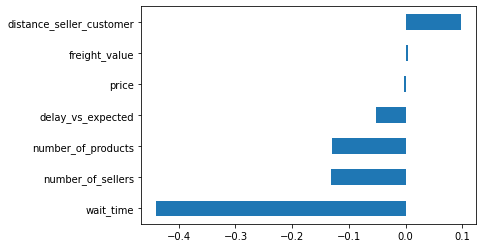

In [237]:
model4.params[1:].sort_values().plot(kind='barh')

❓ What features would you like to consider ?

In [73]:
orders['wait_time'] = sp.zscore(orders['wait_time'])
orders['delay_vs_expected'] = sp.zscore(orders['delay_vs_expected'])
orders['freight_value'] = sp.zscore(orders['freight_value'])
orders['number_of_products'] = sp.zscore(orders['number_of_products'])
orders['number_of_sellers'] = sp.zscore(orders['number_of_sellers'])
model_4 = smf.ols(formula ='review_score ~ wait_time + delay_vs_expected + freight_value + number_of_products + number_of_sellers + price + distance_seller_customer',data = orders).fit()
model_4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     2322.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:03:51   Log-Likelihood:            -1.5258e+05
No. Observations:               95872   AIC:                         3.052e+05
Df Residuals:                   95864   BIC:                         3.052e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.0598      0.007    601.500      0.000       4.047       4.073
wait_time                   -0.4397      0.006    -70.719      0.000      -0.452      -0.428
delay_vs_expected           -0.0515      0.006     -9.023      0.000      -0.063      -0.040
freight_value                0.0043      0.005      0.868      0.385      -0.005       0.014
number_of_products          -0.1297      0.004    -28.861      0.000      -0.139      -0.121
number_of_sellers           -0.1314      0.004    -32.747      0.000      -0.139      -0.124
price                    -1.414e-05   2.03e-05     -0.696      0.486    -5.4e-05    2.57e-05
distance_seller_customer     0.0002   7.75e-06     20.984      0.000       0.000       0.000
==============================================================================
Omnibus:                    18749.799   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37820.902
Skew:                          -1.175   Prob(JB):                         0.00
Kurtosis:                       4.986   Cond. No.                     1.87e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [74]:
orders.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,-0.431195,15.544063,-0.161782,delivered,0,0,4,-0.264596,-0.112545,29.99,-0.652042,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,0.134174,19.137766,-0.161782,delivered,0,0,4,-0.264596,-0.112545,118.70,0.000467,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,-0.329909,26.639711,-0.161782,delivered,1,0,5,-0.264596,-0.112545,159.90,-0.164054,514.130333
3,949d5b44dbf5de918fe9c16f97b45f8a,0.073540,26.188819,-0.161782,delivered,1,0,5,-0.264596,-0.112545,45.00,0.206816,1822.800366
4,ad21c59c0840e6cb83a9ceb5573f8159,-1.019540,12.112049,-0.161782,delivered,1,0,5,-0.264596,-0.112545,19.90,-0.652042,30.174037


⚖️ Standardize your features.

*Do you remember why we need to perform this operation before running a `Multivariate regression` ?*

<details>
    <summary>- 💡 Answer 💡-</summary>

👉 In a `multivariate linear regression`, we are trying to measure the impact of each feature on the target. 
    
⚠️ Because of scale effects, some features will wrongly be seen as more important than others 
    
    *Ex: if you have a feature "number of bedrooms" from 1 to 5 and a feature "surface" from 20 to 200 sqm, the ranges of these two features are quite different...*

📅 When we will discover Machine Learning Algorithms, we will also need to perform some scaling operations before trying to predict any target.

<AxesSubplot:xlabel='number_of_products', ylabel='number_of_sellers'>

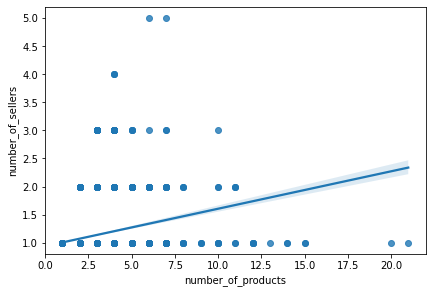

In [63]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.regplot(x='number_of_products', y='number_of_sellers', data=orders, ci=95)

👉 Create your `model4` and train it.

---
❓ What are the most important features? (make a bar chart to visualize them well)
- How has the overall regression performance changed?
- Is this regression statistically significant?

<AxesSubplot:ylabel='0'>

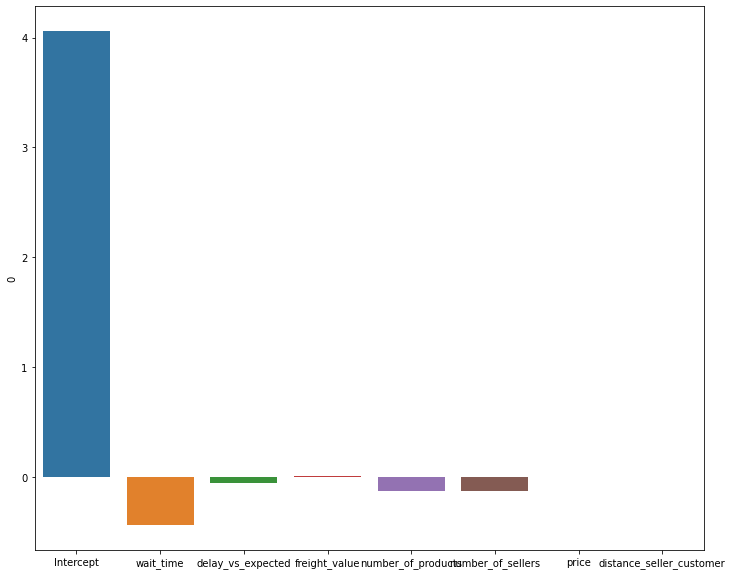

In [185]:
plt.figure(figsize = (12,10))
sns.barplot(x=df_4.index, y=df_4[0])

<details>
    <summary>- 💡Explanations 💡 -</summary>
    

- `wait_time` is the biggest explanatory variable
- The more `products` and `sellers` there are for a single order, the lower the `review_score` seems to be
- Distance also plays a role in customers' satisfaction.
- Depending on your choice of feature, you may not be able to conclude anything about `price` and `freight_value` if their p-values are too high
    
- Overall, this multivariate regression remains statistically significant, because its F-statistics are much greater than 1 (at least one feature has a very low p-value)

- R-squared hasn't increased by much. Most of the explainability of `review_score` lies outside of the orders dataset.

⚠️ Low R-squared is common when the number of observations (n) is much higher than the number of features (p). Relevant insights can still be derived from such regressions, provided they are statistically significant
</details>



## 3 - Check model performance

⚠️ Regression performance should not be measured only by its R-squared!  

👀 Always visualize the distribution of the predictions, and especially the residuals.

❓ Compute the residuals.

You should see that the mean of the residuals is equal to 0 (always verified in a linear regression context)

In [241]:
predicted_review_score = model4.predict(orders_standardized[features])
residuals = predicted_review_score - orders_standardized.review_score

In [242]:
rmse = (residuals**2).mean()**0.5
rmse

1.1883154116821097

🧮 Compute the associated RMSE.

In [243]:
y_actual = orders['wait_time']
y_predicted = orders['wait_time'] + model_4.resid
MSE = mean_squared_error(y_actual, y_predicted)
RMSE = math.sqrt(MSE)
RMSE

1.1883154116821095

In [ ]:
errors = orders['expected wait time'1 - orders!'wait time'
(baseline RMSE = ((errors**>) . means()) **0. 5

📊 Plot the `residuals` in a histogram.

Text(0.5, 1.0, 'residuals density plot')

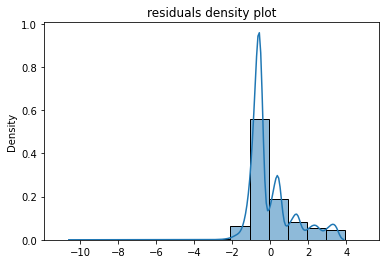

In [244]:
sns.histplot(residuals, kde=True, stat='density', discrete=True)
plt.title('residuals density plot')

❓ Can you guess why the residual distplot has such a strange shape? 

*Hint:*<br/>
👉 Plot, on the same graph, both the distribution of the `review_score` and the distribution of the `predicted_review_score`.

Text(0.5, 1.0, 'distribution of predicted and actual values')

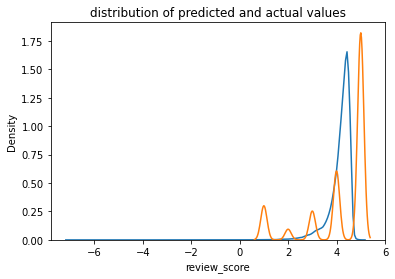

In [245]:
sns.kdeplot(predicted_review_score, label='predicted review score')
sns.kdeplot(orders.review_score, label = 'actual review score')
plt.title('distribution of predicted and actual values')

📈 Actually, using `seaborn`, we could have already plotted a `regression line` of the `review_score` vs. the `delay_vs_expected`

Do it once with a sub-`sample` of the population, and once with the `entire population`.

(0.0, 5.939829389453158)

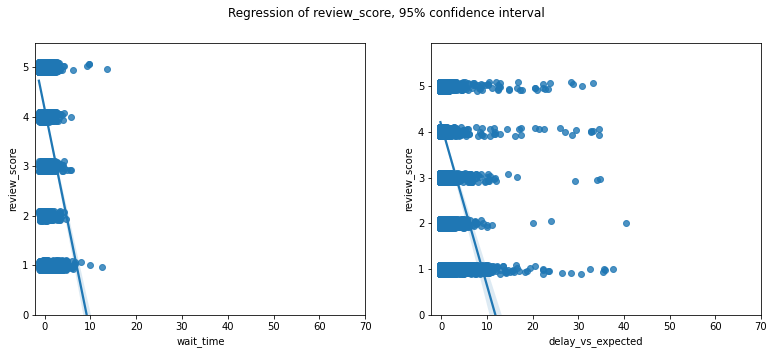

In [246]:
sample = orders.sample(10000, random_state=42)
plt.figure(figsize=(13,5))
plt.suptitle('Regression of review_score, 95% confidence interval')
plt.subplot(1,2,1)
sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1, ci=95)
plt.xlim(right=70)
plt.ylim(bottom=0)

plt.subplot(1,2,2)
sns.regplot(x = orders.delay_vs_expected, y= orders.review_score, y_jitter=.1, ci=95)
plt.xlim(right=70)
plt.ylim(bottom=0)

☝️ You can see that it is hard to regress the `review_score` of an order vs. its `wait_time`. because the `review_score` is a discrete number that could also be interpreted as a category: 1 (very bad), 2 (bad), 3 (average), 4 (good), 5 (excellent).

📅 In the next session, you will discover a new model: the `Logistic Regression` which, despite its name, is a `Classification Algorithm` 

☝️ So in the end, our model is not so great, for two reasons:
- First, because we don't have enough features to explain a significant proportion of the review_scores (low R-squared)
- Second, because we are trying to fit a "linear regression" function to a discrete classification problem

💡 So instead on working on individual orders and trying to explain their discrete `review_score` based on the `wait_time`, we will focus our analysis on the sellers' level, aggregating the orders by sellers in the next challenge.

🏁 Great job! 

💾 Don't forget to *save*, *commit* and *push* this notebook when you are done!

In [ ]:
!git add .
!git commit